In [12]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.fftpack import fft2, ifft2

import torch
import torch.nn.functional as F

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# FISTA to recover this image from a gaussian blurred version
def gaussian_kernel(size, sigma):
  """Generates a 2D Gaussian kernel."""
  x, y = torch.meshgrid(torch.arange(-size//2 + 1, size//2 + 1),
                        torch.arange(-size//2 + 1, size//2 + 1))
  g = torch.exp(-((x**2 + y**2)/(2.0*sigma**2)))
  return g / g.sum()

def fista(y, A, kernel, alpha, lam, max_iter=100, tol=1e-4):
  """Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)."""
  n_blurs = kernel.shape[0]
  kernel = kernel.repeat(1,n_blurs,1,1)  
  x = torch.zeros_like(y)
  z = x.clone()
  t = torch.tensor(1.0)
  loss_list = []
  for _ in range(max_iter):
    x_old = x.clone()
    loss_list.append((torch.linalg.norm(A(z, kernel) - y) / 2.0).item())
    z = z - alpha*At((A(z, kernel) - y), kernel)  # gradient step
    x = soft_threshold(z, lam)  # proximal step (thresholding)
    t_old = t                   # momentum step
    t = (1 + torch.sqrt(1 + 4 * t**2)) / 2
    z = x + ((t_old - 1) / t) * (x - x_old)
    if torch.linalg.norm(x - x_old) < tol:
      break
  x = soft_threshold(z, lam)
  return x, loss_list

def ista(y, A, kernel, alpha, lam, max_iter=100, tol=1e-4):
  """Iterative Shrinkage-Thresholding Algorithm (FISTA)."""
  n_blurs = kernel.shape[0]
  kernel = kernel.repeat(1,n_blurs,1,1)
  x = torch.zeros_like(y)
  z = x.clone()
  loss_list = []
  for _ in range(max_iter):
    x_old = x.clone()
    loss_list.append((torch.linalg.norm(A(z, kernel) - y) / 2.0).item())
    z = z - alpha*At((A(z, kernel) - y), kernel)  # gradient step
    x = soft_threshold(z, lam)  # proximal step (thresholding)
    if torch.linalg.norm(x - x_old) < tol:
      break
  return x, loss_list

def soft_threshold(x, lam):
  """Soft-thresholding operator."""
  return torch.sign(x) * torch.maximum(torch.abs(x) - lam, torch.tensor(0.0))


def gradient_descent(y, A, kernel, alpha, max_iter=100, tol=1e-4):
  """Vanilla solver: GD."""
  n_blurs = kernel.shape[0]
  kernel = kernel.repeat(1,n_blurs,1,1)
  x = torch.zeros_like(y)
  z = x.clone()
#   t = torch.tensor(1.0)
  loss_list = []
  for _ in range(max_iter):
    x_old = x.clone()
    loss_list.append((torch.linalg.norm(A(z, kernel) - y) / 2.0).item())
    z = z - alpha*At((A(z, kernel) - y), kernel)        # gradient step
    x = z
    if torch.linalg.norm(x - x_old) < tol:
      break
  return x, loss_list


# Define the forward operator (A) as convolution with the kernel
def A(x, kernel, device='cuda'):
  return F.conv2d(x, kernel, padding='same').to(device)

# Define the adjoint operator (A.T) as convolution with the flipped kernel
def At(x, kernel, device='cuda'):
    # Flip the kernel horizontally and vertically (180 degrees)
    flipped_kernel = torch.flip(kernel, dims=[2, 3])
    return F.conv2d(x, flipped_kernel, padding='same').to(device)

In [13]:
def checkAdjoint(A,At,x,kernel):
    Ax = A(x,kernel)
    y = torch.rand_like(Ax)
    Aty = At(y,kernel)
    # Reshape tensors to 1D
    Ax_flat = Ax.view(-1)
    y_flat = y.view(-1)
    x_flat = x.view(-1)
    Aty_flat = Aty.view(-1)
    # Compute inner products
    innerProduct1 = torch.dot(Ax_flat, y_flat)
    innerProduct2 = torch.dot(x_flat, Aty_flat)
    # Compute error
    error = torch.abs(innerProduct1 - innerProduct2) / torch.max(torch.abs(innerProduct1), torch.abs(innerProduct2))
    assert error < 1e-9, '"A.T" is not the adjoint of "A". Check the definitions of these operators.'
    return error

x = torch.rand((1,20,20)).double().cuda()
kernel = torch.randint(0, 2, (3, 3)).unsqueeze(0).unsqueeze(0).double().cuda()
checkAdjoint(A,At,x, kernel)

tensor(0., device='cuda:0', dtype=torch.float64)

In [14]:
from skimage import data, img_as_float
from skimage import color, morphology
from skimage.transform import resize
from PIL import Image

device = 'cuda'
image_path = 'testset/Set12/01.png'
image = Image.open(image_path).resize((128, 128))
image = np.array(image)/255.

# # sparse image
# image = color.rgb2gray(data.hubble_deep_field())[:500, :500] 
# image = resize(image, (128, 128), anti_aliasing=True)

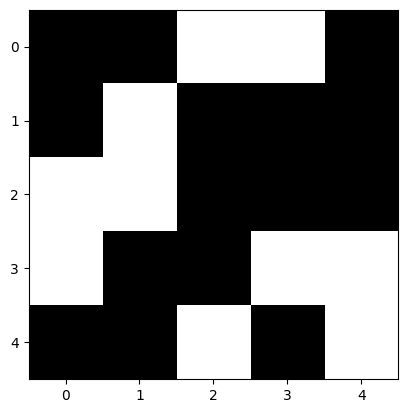

In [15]:
torch.manual_seed(188)

kernel_size = 5
# kernel_size = 128

# # Gaussian kernel
# sigma = 0.5
# kernel = gaussian_kernel(kernel_size, sigma).unsqueeze(0).unsqueeze(0).double().to(device)

#Binary kernel
kernel = torch.randint(0, 2, (kernel_size, kernel_size)).unsqueeze(0).unsqueeze(0).double().to(device)

plt.figure()
plt.imshow(kernel.cpu().squeeze(0).squeeze(0), cmap='gray')

# # compute conditon # of the kernel
# kernel_ft = torch.fft.fft2(kernel, s=[128,128])
# kernel_energy = kernel_ft.real
# kernel_condition = (kernel_energy.max()/kernel_energy.min())
# kernel_condition

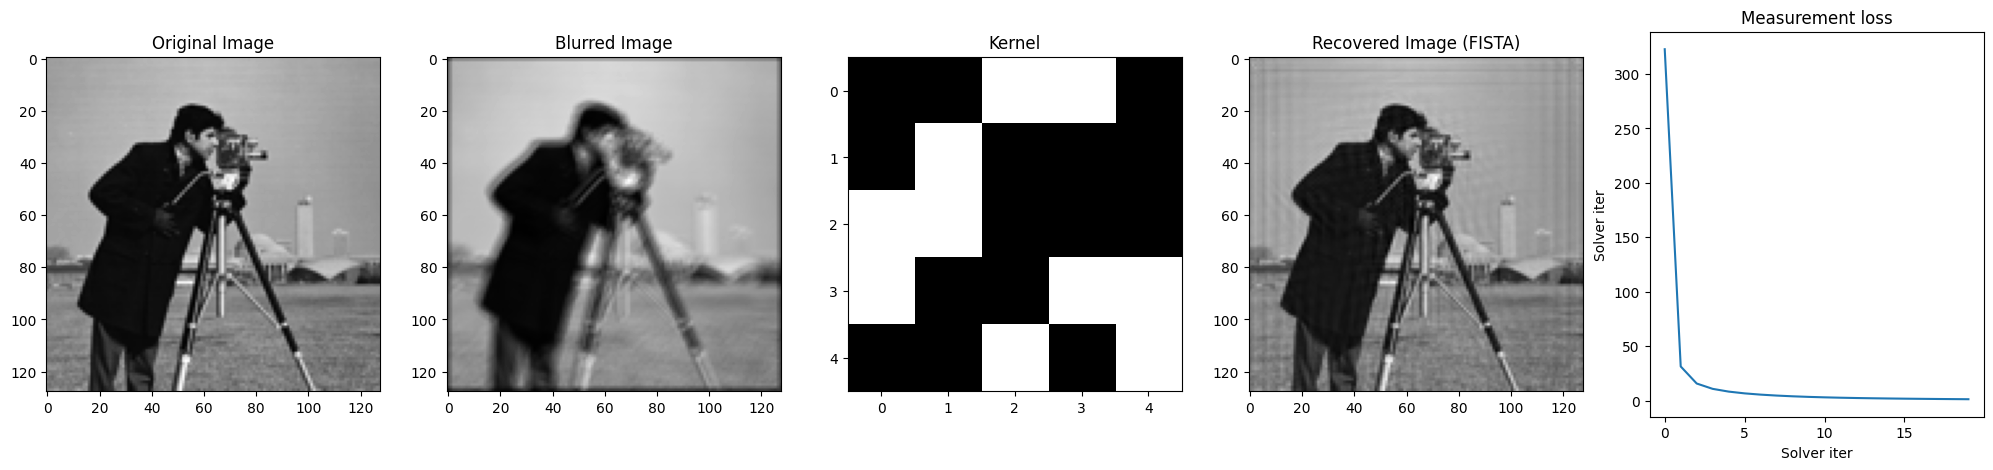

In [16]:
original_image = torch.from_numpy(image).unsqueeze(0).to(device)
blurred_image = F.conv2d(original_image, kernel, padding='same').to(device)

# Perform FISTA deconvolution
alpha = 0.01 # gradient step size
lambda_reg = 0.00 # Regularization parameter
solver_iter = 20
recovered_image_fista, loss_list_fista = fista(blurred_image, A, kernel, alpha, lambda_reg, solver_iter)

# Display the original, blurred, and recovered images
plt.figure(figsize=(25, 5))
plt.subplot(151)
plt.imshow(original_image.cpu().squeeze(0), cmap='gray')
plt.title('Original Image')
#
plt.subplot(152)
plt.imshow(blurred_image.cpu().squeeze(0), cmap='gray')
plt.title('Blurred Image')
#
plt.subplot(153)
plt.imshow(kernel.cpu().squeeze(0).squeeze(0), cmap='gray')
plt.title('Kernel')
#
plt.subplot(154)
plt.imshow(recovered_image_fista.cpu().squeeze(0), cmap='gray')
plt.title('Recovered Image (FISTA)')
#
plt.subplot(155)
plt.plot(loss_list_fista)
plt.title('Measurement loss')
plt.xlabel('Solver iter')
plt.ylabel('Solver iter')
plt.show()

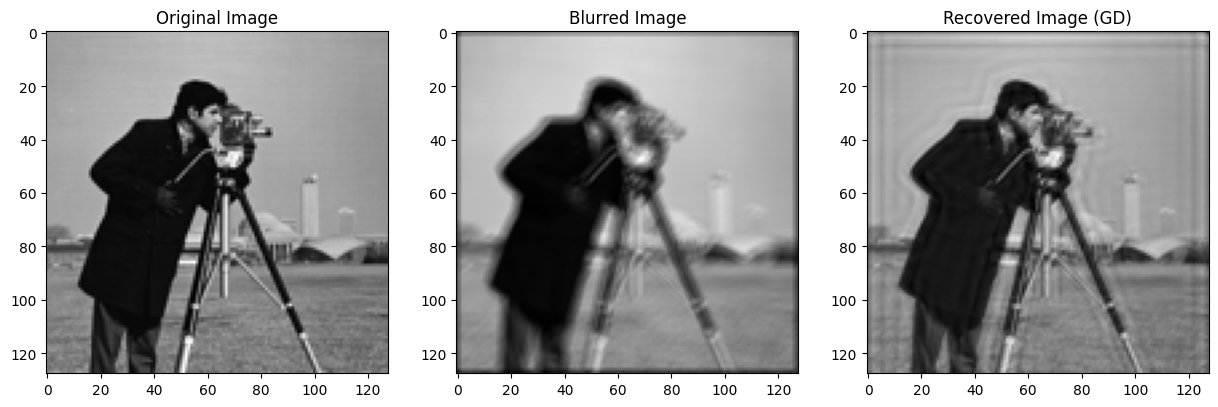

In [17]:
# Perform GD deconvolution
recovered_image_gd, loss_list_gd = gradient_descent(blurred_image, A, kernel, alpha, solver_iter)

# Display the original, blurred, and recovered images
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(original_image.cpu().squeeze(0), cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(blurred_image.cpu().squeeze(0), cmap='gray')
plt.title('Blurred Image')
plt.subplot(133)
plt.imshow(recovered_image_gd.cpu().squeeze(0), cmap='gray')
plt.title('Recovered Image (GD)')
plt.show()

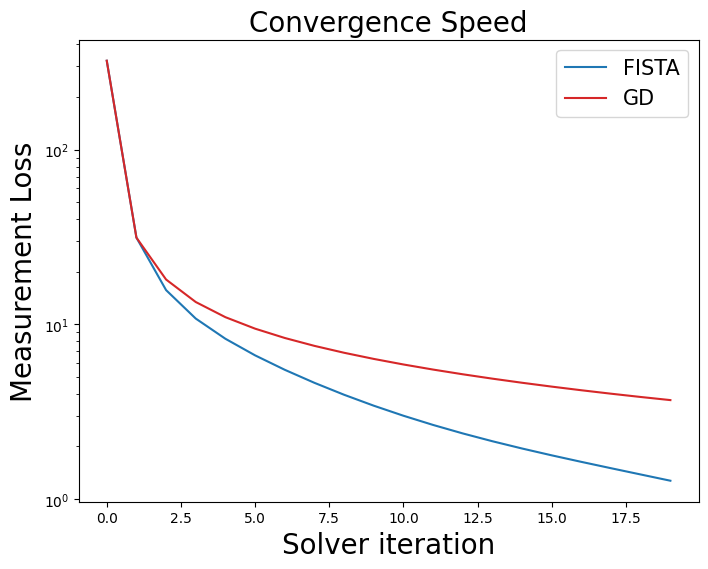

In [18]:
# Compare convergence speed of FISTA vs GD
fig,axe = plt.subplots(figsize=(8, 6)) # Use plt.subplots to create a figure and axes
axe.plot(loss_list_fista, label='FISTA', color='tab:blue')
axe.plot(loss_list_gd, label='GD', color='tab:red')
axe.set_xlabel('Solver iteration', fontsize = 20)
axe.set_ylabel('Measurement Loss', fontsize = 20)
axe.set_title('Convergence Speed', fontsize = 20)
axe.set_yscale('log')
axe.legend(fontsize = 15)
plt.show()

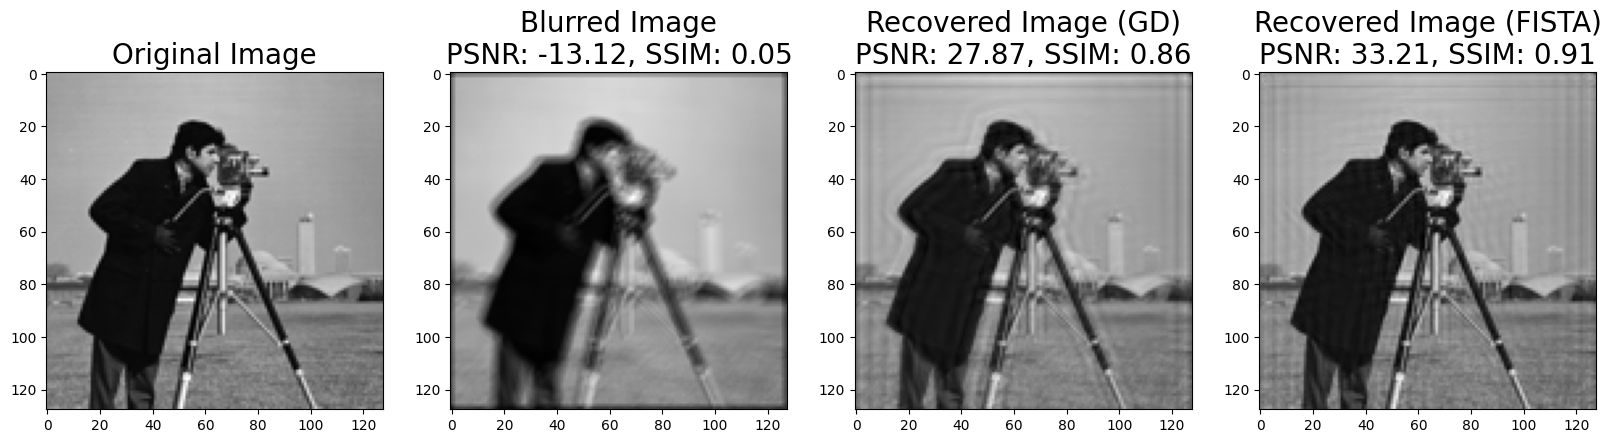

In [19]:
# plot visual examples
plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.imshow(original_image.squeeze(0).cpu(), cmap='gray')
plt.title('Original Image', fontsize = 20)

plt.subplot(142)
plt.imshow(blurred_image.squeeze(0).cpu(), cmap='gray')
psnr_blur = psnr(original_image.squeeze(0).cpu().numpy(), blurred_image.squeeze(0).cpu().detach().numpy())
ssim_blur = ssim(original_image.squeeze(0).cpu().numpy(), blurred_image.squeeze(0).cpu().detach().numpy(), data_range=1.0)
plt.title(f'Blurred Image\nPSNR: {psnr_blur:.2f}, SSIM: {ssim_blur:.2f}', fontsize = 20)

plt.subplot(143)
plt.imshow(recovered_image_gd.squeeze(0).cpu(), cmap='gray')
psnr_gd = psnr(original_image.squeeze(0).cpu().numpy(), recovered_image_gd.squeeze(0).cpu().detach().numpy())
ssim_gd = ssim(original_image.squeeze(0).cpu().numpy(), recovered_image_gd.squeeze(0).cpu().detach().numpy(), data_range=1.0)
plt.title(f'Recovered Image (GD)\nPSNR: {psnr_gd:.2f}, SSIM: {ssim_gd:.2f}', fontsize = 20)

plt.subplot(144)
plt.imshow(recovered_image_fista.squeeze(0).cpu(), cmap='gray')
psnr_fista = psnr(original_image.squeeze(0).cpu().numpy(), recovered_image_fista.squeeze(0).cpu().detach().numpy())
ssim_fista = ssim(original_image.squeeze(0).cpu().numpy(), recovered_image_fista.squeeze(0).cpu().detach().numpy(), data_range=1.0)
plt.title(f'Recovered Image (FISTA)\nPSNR: {psnr_fista:.2f}, SSIM: {ssim_fista:.2f}', fontsize = 20)

plt.show()


### Learn FISTA Momentum

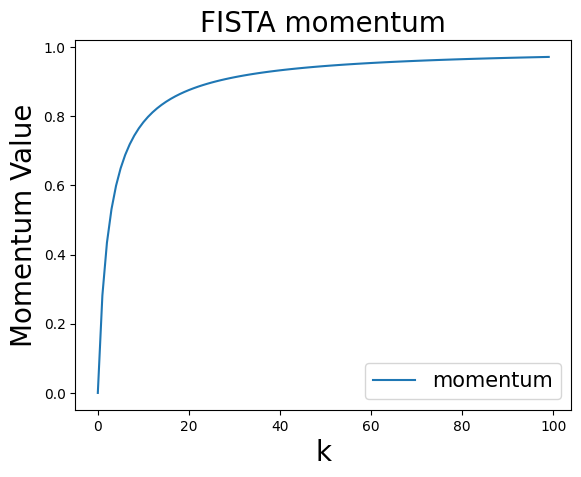

In [20]:
def gen_momentums(solver_iters):
    """
    Generate momentum sequence from FISTA/NAG expression,
    which is function of solver iteration K
    """
    t_0 = torch.tensor(1.0)
    t_old = t_0
    momentum_list = []
    t_list = []
    for _ in range(solver_iters):
        t_new = (1 + torch.sqrt(1 + 4 * t_old**2)) / 2
        t_list.append(t_new)
        momentum = ((t_old - 1) / t_new)
        momentum_list.append(momentum)
        # print(f't={t_new}, momentum={momentum}')
        t_old = t_new
    return momentum_list

momentum_list = gen_momentums(100)
# plt.plot(t_list, label='t')
plt.title("FISTA momentum", fontsize = 20)
plt.plot(momentum_list, label='momentum')
plt.xlabel('k', fontsize = 20)
plt.ylabel('Momentum Value', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

In [21]:
from pathlib import Path
# load Set12 as tensor
def load_dataset(size=10, set_path='testset/Set12', device='cuda'):
    set_path = Path(set_path)
    dataset = []
    for i in range(size):
        file_name = f'0{i+1}.png' if i+1<10 else f'{i+1}.png'
        image = Image.open(set_path/file_name).resize((128, 128))
        image = np.array(image)/255.
        dataset.append(image)
    train_dataset_tensor = np.array(dataset)
    train_dataset_tensor = torch.from_numpy(train_dataset_tensor).unsqueeze(1)

    dataset = []
    for i in range(12-size):
        file_name = f'{i+11}.png'
        image = Image.open(set_path/file_name).resize((128, 128))
        image = np.array(image)/255.
        dataset.append(image)
    test_dataset_tensor = np.array(dataset)
    test_dataset_tensor = torch.from_numpy(test_dataset_tensor).unsqueeze(1)    
    return train_dataset_tensor.to(device), test_dataset_tensor.to(device)

In [22]:
def fista_learn_momentum(y, A, kernel, momentum_schedule, alpha, lam, max_iter=100, tol=1e-4):
    """Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)."""
    n_blurs = kernel.shape[0]
    kernel = kernel.repeat(1,n_blurs,1,1)
    x = torch.zeros_like(y)
    z = x.clone()
    t = torch.tensor(1.0)
    loss_list = []
    for iter in range(max_iter):
        x_old = x.clone()
        loss_list.append((torch.linalg.norm(A(z, kernel) - y) / 2.0).item())
        # gradient step
        z = z - alpha*At(A(z, kernel) - y, kernel)
        # proximal step (thresholding)
        x = soft_threshold(z, lam)
        # momentum step
        # t_old = t
        # t = (1 + torch.sqrt(1 + 4 * t**2)) / 2
        # z = x + ((t_old - 1) / t) * (x - x_old)        
        momentum = momentum_schedule[iter]
        z = x + momentum * (x - x_old)
        if torch.linalg.norm(x - x_old) < tol:
            break
    x = soft_threshold(z, lam)
    return x, loss_list

In [23]:
def fista_learn_general(y, A, kernel, momentum_schedule, alpha, lam, max_iter=100, tol=1e-4):
    """Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)."""
    # print(kernel.shape)
    n_blurs = kernel.shape[0]
    kernel = kernel.repeat(1,n_blurs,1,1)
    # print(kernel.shape)
    x = torch.zeros_like(y)
    z = x.clone()
    
    x_k_list = []
    loss_list = []
    for iter in range(max_iter):
        x_old = x.clone()
        x_k_list.append(x_old)
        loss_list.append((torch.linalg.norm(A(z, kernel) - y) / 2.0).item())
        # gradient step
        step_size = alpha if alpha.dim()==0 else alpha[iter]
        z = z - step_size*At(A(z, kernel) - y, kernel)
        # proximal step (thresholding)
        x = soft_threshold(z, lam)
        # momentum step       
        momentum = momentum_schedule[iter]
        if momentum.dim()==0:       # unrolling as mu_k (x_k-x_k-1)
            z = x + momentum * (x - x_old)
        elif momentum.shape[0]==2:  # unrolling as a_k x_k + b_k x_k-1
            z = x + momentum[0]*x + momentum[1]*x_old
        elif momentum.shape[0]>=2:
            z = x*momentum[0]       # unrolling as sum_t a_t x_t, where t=0,1,..,k
            for x_k, m in zip(x_k_list, momentum[1:]):
                z += x_k * m
        else:
            print("momentum in wrong shape!")
        if torch.linalg.norm(x - x_old) < tol:
            break
    x = soft_threshold(z, lam)
    return x, loss_list

In [71]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_epoches = 500
solver_iter = 20
unrolling_setup = "difference" # "difference", "linear", "general"

momentum_list = gen_momentums(solver_iter)
if unrolling_setup=="difference":
    # unrolling as mu_k (x_k-x_k-1), 
    # learn mu_k
    momentum_schedule_init_0 = (0.05*torch.ones(solver_iter)).to(device)
    # momentum directly initialized from m_k
    momentum_schedule_init_1 = torch.tensor(momentum_list).to(device)
elif unrolling_setup=="linear":
    # unrolling as a_k x_k + b_k x_k-1
    # learn a_k,bk
    momentum_schedule_init_0 = torch.zeros((solver_iter,2)).to(device)
    # momentum directly initialized from m_k
    momentum_schedule_init_1 = torch.tensor(momentum_list).unsqueeze(1).repeat(1,2).to(device)
    momentum_schedule_init_1[:, 1] = -1.0*momentum_schedule_init_1[:, 1]
elif unrolling_setup=="general":
    # unrolling as sum_k=0^K(a_k*x_k + b_k*x_k-1)
    # learn a_k,bk
    momentum_schedule_init_0 = (0.01*torch.ones((solver_iter,solver_iter))).to(device)
    momentum_schedule_init_1 = (0.001*torch.ones((solver_iter,solver_iter))).to(device)


optimizer_schedule_init_0 = torch.optim.Adam([momentum_schedule_init_0], lr=1e-3)
optimizer_schedule_init_1 = torch.optim.Adam([momentum_schedule_init_1], lr=1e-3)

# # Gaussian kernel
# kernel_size = 7
# sigma = 2
# kernel = gaussian_kernel(kernel_size, sigma).unsqueeze(0).unsqueeze(0).double().to(device)

# # Binary kernel
# Single blur
torch.manual_seed(188)
kernel_batch = torch.randint(0, 2, (1, 1,kernel_size, kernel_size)).double().to(device)

# # Multiple blur
# torch.manual_seed(188)
# n_blurs = 10
# kernel_batch = torch.randint(0, 2, (n_blurs, 1, kernel_size, kernel_size)).double().to(device)

# Single image
original_image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)
blurred_image = F.conv2d(original_image, kernel_batch, padding='same').to(device)

# # Multiple images
# original_image, test_image = load_dataset()
# blurred_image = F.conv2d(original_image, kernel_batch, padding='same').to(device)


# other hyperparameters
alpha = torch.tensor(0.01).to(device)
lambda_reg = 0.000 # shrinkage regularization parameter

In [72]:
loss_list_recon_gd = []
loss_list_recon_fista = []
loss_list_recon_init_0 = []
loss_list_recon_init_1 = []
for i in tqdm(range(train_epoches)):
    momentum_schedule_init_0.requires_grad = True
    momentum_schedule_init_1.requires_grad = True
    optimizer_schedule_init_0.zero_grad()
    optimizer_schedule_init_1.zero_grad()

    # Learn momentum init. 0
    x_hat, _ = fista_learn_general(blurred_image, A, kernel_batch, momentum_schedule_init_0, alpha, lambda_reg, solver_iter)
    # Compute reconstruction loss
    loss = (torch.norm((x_hat - original_image), p=2))**2  # equivalent to nn.MSEloss(reduction="sum")
    loss.backward()
    # update learning variable
    optimizer_schedule_init_0.step()
    loss_list_recon_init_0.append(loss.item())

    # Learn momentum init. 1
    x_hat, _ = fista_learn_general(blurred_image, A, kernel_batch, momentum_schedule_init_1, alpha, lambda_reg, solver_iter)
    # Compute reconstruction loss
    loss = (torch.norm((x_hat - original_image), p=2))**2  # equivalent to nn.MSEloss(reduction="sum")
    loss.backward()
    # update learning variable
    optimizer_schedule_init_1.step()
    loss_list_recon_init_1.append(loss.item())
    
    
    # collect reconstruction loss for Original FISTA and GD
    with torch.no_grad():
        # FISTA    
        x_hat, _ = fista(blurred_image, A, kernel_batch, alpha, lambda_reg, solver_iter)      
        loss = (torch.norm((x_hat - original_image), p=2))**2
        loss_list_recon_fista.append(loss.item())
        # GD
        x_hat, _ = gradient_descent(blurred_image, A, kernel_batch, alpha, solver_iter)
        loss = (torch.norm((x_hat - original_image), p=2))**2
        loss_list_recon_gd.append(loss.item())    

100%|██████████| 500/500 [00:53<00:00,  9.33it/s]


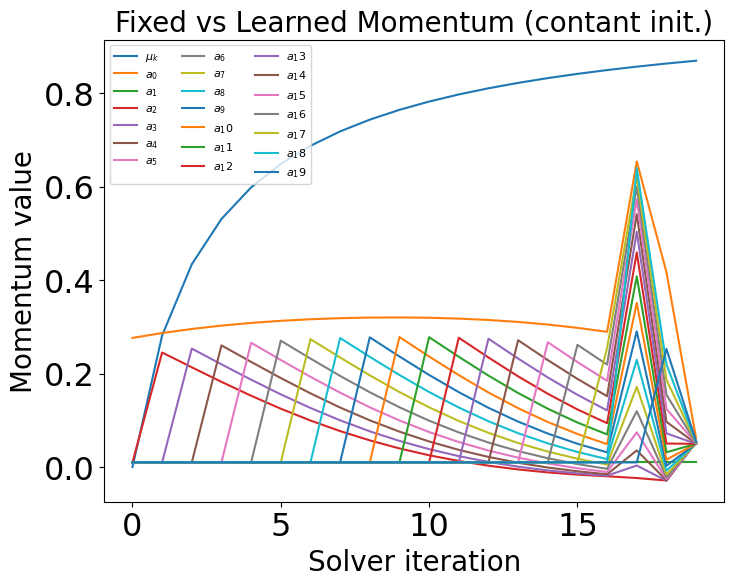

In [77]:
# plot learned momentum
if unrolling_setup=="difference":
    # unrolling as mu_k(x_k-x_k-1)
    # compare convergence speed of fista vs gd
    plt.rcParams.update({'font.size': 23})
    fig,axe = plt.subplots(figsize=(8, 6)) # Use plt.subplots to create a figure and axes
    axe.plot(momentum_list[:], label='$\mu_k$ computed from Eqn. 8')
    axe.plot(momentum_schedule_init_0[:].tolist(), label='Learned $\mu_k$ init. from $\mathbf{0}$', color='tab:orange') 
    axe.plot(momentum_schedule_init_1[:].tolist(), label='Learned $\mu_k$ init. from Eqn. 8', color='tab:green') 

    axe.set_title('Fixed vs Learned Momentum', fontsize = 23)
    axe.set_xlabel('Solver iteration $k$', fontsize = 23)
    axe.set_ylabel('Momentum value', fontsize = 23)

    axe.legend(fontsize = 18, loc='upper center')
    
elif unrolling_setup=="linear":
    # unrolling as a_k x_k + b_k x_k-1
    plt.rcParams.update({'font.size': 23})
    fig,axe = plt.subplots(figsize=(8, 6))
    axe.plot(momentum_list[:], label=r'$\mu_k$')
    axe.plot(momentum_schedule_init_0[:,0].tolist(), label=r'$a_k$', color='tab:orange') 
    axe.plot(momentum_schedule_init_0[:,1].tolist(), label=r'$b_k$', color='tab:green') 
    axe.set_title('Fixed vs Learned Momentum (init. 0)', fontsize = 23)
    axe.set_xlabel('Solver iteration $k$', fontsize = 23)
    axe.set_ylabel('Momentum value', fontsize = 23)
    axe.legend(fontsize = 18, loc='upper center')
    #
    fig,axe = plt.subplots(figsize=(8, 6))
    axe.plot(momentum_list[:], label=r'$\mu_k$')
    axe.plot(momentum_schedule_init_1[:,0].tolist(), label=r'$a_k$', color='tab:orange') 
    axe.plot(momentum_schedule_init_1[:,1].tolist(), label=r'$b_k$', color='tab:green')
    axe.set_title('Fixed vs Learned Momentum (init. 1)', fontsize = 23)
    axe.set_xlabel('Solver iteration $k$', fontsize = 23)
    axe.set_ylabel('Momentum value', fontsize = 23)
    axe.legend(fontsize = 18, loc='upper center')

elif unrolling_setup=="general":
    # unrolling as sum_k=0^K(a_k*x_k + b_k*x_k-1)
    fig,axe = plt.subplots(figsize=(8, 6)) # Use plt.subplots to create a figure and axes 

    axe.plot(momentum_list[:], label=r'$\mu_k$') 
    for i in range(solver_iter):
        axe.plot(momentum_schedule_init_0[:,i].tolist(), label=f'$a_{i}$')
        
    axe.set_title('Fixed vs Learned Momentum (contant init.)', fontsize = 20)
    axe.set_xlabel('Solver iteration', fontsize = 20)
    axe.set_ylabel('Momentum value', fontsize = 20)
    axe.legend(fontsize = 8, ncol=3)
    plt.show()

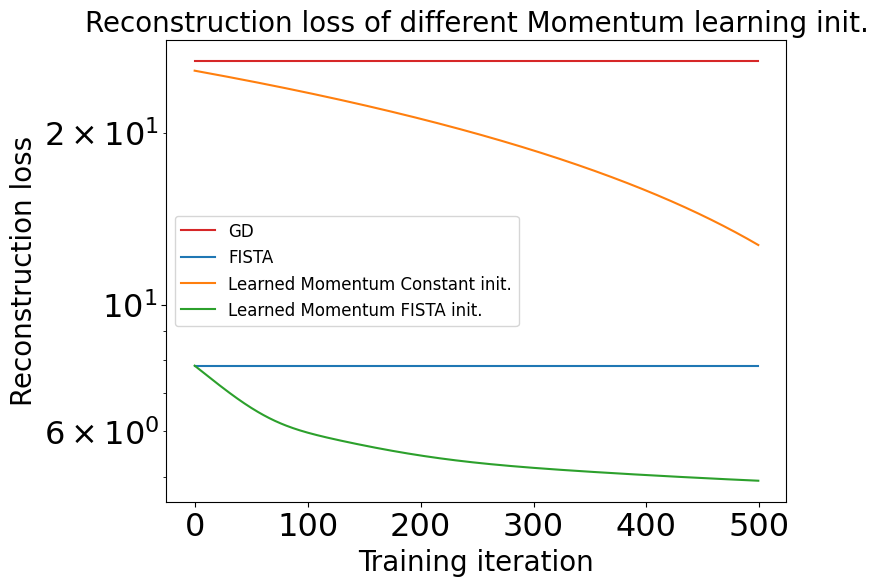

In [31]:
# compare reconstruction loss of different momentum init.
fig,axe = plt.subplots(figsize=(8, 6)) # Use plt.subplots to create a figure and axes
axe.plot(loss_list_recon_gd, label='GD', color='tab:red') 
axe.plot(loss_list_recon_fista, label='FISTA', color='tab:blue') 
axe.plot(loss_list_recon_init_0, label='Learned Momentum Constant init.', color='tab:orange') 
axe.plot(loss_list_recon_init_1, label='Learned Momentum FISTA init.', color='tab:green') 
axe.set_xlabel('Training iteration', fontsize = 20)
axe.set_ylabel('Reconstruction loss', fontsize = 20)
axe.set_title('Reconstruction loss of different Momentum training init.', fontsize = 20)
axe.set_yscale('log')
axe.legend(fontsize = 12, loc='best')
plt.show()

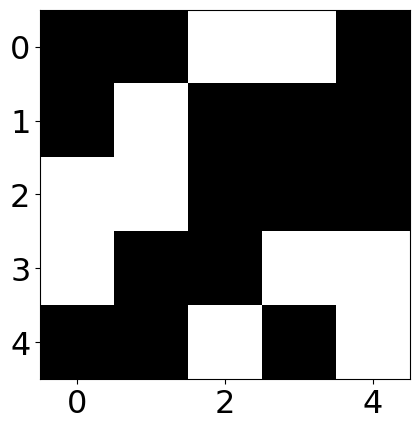

In [63]:
kernel_test = kernel_batch[0].unsqueeze(0)
# kernel_test = kernel_batch

# torch.manual_seed(180)
# kernel_test = torch.randint(0, 2, (13, 13)).unsqueeze(0).unsqueeze(0).double().to(device)

# blurred_image_test = F.conv2d(original_image[:1,:,:,:], kernel_test, padding='same').to(device)
blurred_image_test = F.conv2d(original_image[:1,:,:,:], kernel_test, padding='same').to(device)
# blurred_image_test = F.conv2d(test_image, kernel_test, padding='same').to(device)

if kernel_test.shape[0]==1:
    plt.figure()
    plt.imshow(kernel_test.cpu().squeeze(0).squeeze(0), cmap='gray')
else:
    kernel_display = kernel_test.squeeze(1)  # Now shape is [10, 5, 5]
    # Loop over each 5x5 image and display it using matplotlib
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(2):
        for j in range(5):
            axs[i][j].imshow(kernel_display[int((i+1)*(j+1)-1)].cpu(), cmap='gray')
            # axs[i].axis('off')  # Hide axes for a cleaner look

    plt.tight_layout()
    plt.show()    

# test_alpha = alpha
# test_alpha = alpha/100
test_alpha = torch.tensor(0.01)

# test_alpha = 0.01/20
# test_alpha = 0.01/200
# test_alpha = 0.01/500

with torch.no_grad():
    recovered_image_gd, loss_list_gd = gradient_descent(blurred_image_test, A, kernel_test, test_alpha, solver_iter)
    # recovered_image_fix_momentum, loss_fix_moment = fista_learn_momentum(blurred_image_test, A, kernel_test, torch.tensor(momentum_list).to(device), test_alpha, lambda_reg, solver_iter)
    # recovered_image_learn_momentum_0, loss_learn_moment_0 = fista_learn_momentum(blurred_image_test, A, kernel_test, momentum_schedule_init_0, test_alpha, lambda_reg, solver_iter)
    # recovered_image_learn_momentum_1, loss_learn_moment_1 = fista_learn_momentum(blurred_image_test, A, kernel_test, momentum_schedule_init_1, test_alpha, lambda_reg, solver_iter)
    recovered_image_fix_momentum, loss_fix_moment = fista_learn_general(blurred_image_test, A, kernel_test, torch.tensor(momentum_list).to(device), test_alpha, lambda_reg, solver_iter)
    recovered_image_learn_momentum_0, loss_learn_moment_0 = fista_learn_general(blurred_image_test, A, kernel_test, momentum_schedule_init_0, test_alpha, lambda_reg, solver_iter)
    recovered_image_learn_momentum_1, loss_learn_moment_1 = fista_learn_general(blurred_image_test, A, kernel_test, momentum_schedule_init_1, test_alpha, lambda_reg, solver_iter)    

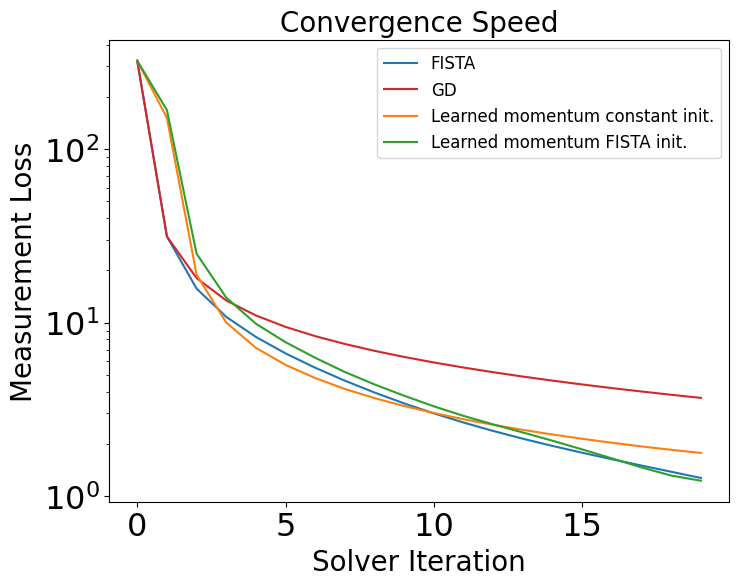

In [64]:
# compare convergence speed of fista vs gd
fig,axe = plt.subplots(figsize=(8, 6)) # Use plt.subplots to create a figure and axes
axe.plot(loss_fix_moment[:], label='FISTA', color='tab:blue')
axe.plot(loss_list_gd, label='GD', color='tab:red')
axe.plot(loss_learn_moment_0[:], label='Learned momentum constant init.', color='tab:orange') 
axe.plot(loss_learn_moment_1[:], label='Learned momentum FISTA init.', color='tab:green') 

axe.set_xlabel('Solver Iteration', fontsize = 20)
axe.set_ylabel('Measurement Loss', fontsize = 20)
axe.set_title('Convergence Speed', fontsize = 20)
axe.set_yscale('log')
axe.legend(fontsize = 12)
plt.show()

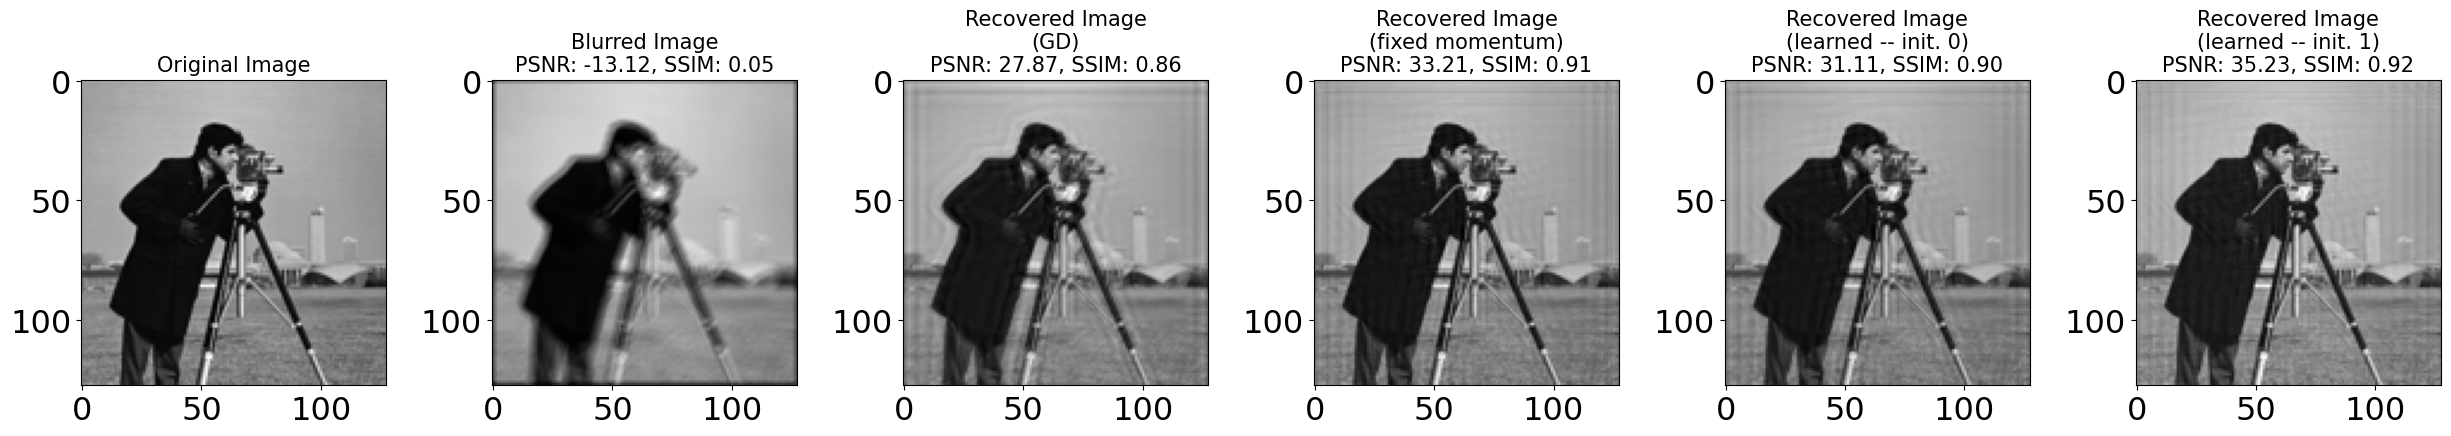

In [67]:
img_id = 0 # 0,5,3
blur_id = 0
original_image_np = original_image[img_id][blur_id].squeeze(0).cpu().numpy()
# original_image_np = test_image[img_id][blur_id].squeeze(0).cpu().numpy()
# blurred_image_np = blurred_image[img_id][blur_id].squeeze(0).cpu().detach().numpy()
blurred_image_np = blurred_image_test[img_id][blur_id].squeeze(0).cpu().detach().numpy()
with torch.no_grad():
    recovery_image_fix_momentum_np = recovered_image_fix_momentum[img_id][blur_id].squeeze(0).detach().cpu().detach().numpy()
    recovered_image_learn_momentum_0_np = recovered_image_learn_momentum_0[img_id][blur_id].squeeze(0).cpu().detach().numpy()
    recovered_image_learn_momentum_1_np = recovered_image_learn_momentum_1[img_id][blur_id].squeeze(0).cpu().detach().numpy()
    recovered_image_gd_np = recovered_image_gd[img_id][blur_id].squeeze(0).cpu().detach().numpy()


fontsize=15

plt.figure(figsize=(25, 5))
plt.subplot(161)
plt.imshow(original_image_np, cmap='gray')
plt.title('Original Image', fontsize = fontsize)

plt.subplot(162)
plt.imshow(blurred_image_np, cmap='gray')
psnr_blur = psnr(original_image_np, blurred_image_np)
ssim_blur = ssim(original_image_np, blurred_image_np, data_range=1.0)
plt.title(f'Blurred Image\nPSNR: {psnr_blur:.2f}, SSIM: {ssim_blur:.2f}', fontsize = fontsize)

plt.subplot(163)
plt.imshow(recovered_image_gd_np, cmap='gray')
psnr_fista = psnr(original_image_np, recovered_image_gd_np)
ssim_fista = ssim(original_image_np, recovered_image_gd_np, data_range=1.0)
plt.title(f'Recovered Image\n(GD)\nPSNR: {psnr_fista:.2f}, SSIM: {ssim_fista:.2f}', fontsize = fontsize)

plt.subplot(164)
plt.imshow(recovery_image_fix_momentum_np, cmap='gray')
psnr_fista = psnr(original_image_np, recovery_image_fix_momentum_np)
ssim_fista = ssim(original_image_np, recovery_image_fix_momentum_np, data_range=1.0)
plt.title(f'Recovered Image\n(fixed momentum)\nPSNR: {psnr_fista:.2f}, SSIM: {ssim_fista:.2f}', fontsize = fontsize)

plt.subplot(165)
plt.imshow(recovered_image_learn_momentum_0_np, cmap='gray')
psnr_gd = psnr(original_image_np, recovered_image_learn_momentum_0_np)
ssim_gd = ssim(original_image_np, recovered_image_learn_momentum_0_np, data_range=1.0)
# plt.title(f'Recovered Image\n(learned momentum -- constant init.)\nPSNR: {psnr_gd:.2f}, SSIM: {ssim_gd:.2f}', fontsize = fontsize)
plt.title(f'Recovered Image\n(learned -- init. 0)\nPSNR: {psnr_gd:.2f}, SSIM: {ssim_gd:.2f}', fontsize = fontsize)

plt.subplot(166)
plt.imshow(recovered_image_learn_momentum_1_np, cmap='gray')
psnr_fista = psnr(original_image_np, recovered_image_learn_momentum_1_np)
ssim_fista = ssim(original_image_np, recovered_image_learn_momentum_1_np, data_range=1.0)
# plt.title(f'Recovered Image\n(learned momentum -- FISTA init.)\nPSNR: {psnr_fista:.2f}, SSIM: {ssim_fista:.2f}', fontsize = fontsize)
plt.title(f'Recovered Image\n(learned -- init. 1)\nPSNR: {psnr_fista:.2f}, SSIM: {ssim_fista:.2f}', fontsize = fontsize)

plt.tight_layout()
plt.show()